In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import geopandas as gpd
import numpy as np

In [20]:
distance_matrix_df = pd.read_csv('distance_matrix.csv', index_col=0)
distance_matrix_straigt_line_df = pd.read_csv('distance_matrix_straight_line.csv', index_col=0)
path_matrix_df = pd.read_pickle('path_matrix_df.pkl')


# Zamieńmy wartości na km z dokładnością do metra
distance_matrix_df = distance_matrix_df / 1000
distance_matrix_df = distance_matrix_df.round(3)

distance_matrix_straigt_line_df = distance_matrix_straigt_line_df / 1000
distance_matrix_straigt_line_df = distance_matrix_straigt_line_df.round(3)


In [3]:
zabki_gdf = gpd.read_file('zabki_krakow.geojson')
zabki_gdf = zabki_gdf.to_crs(epsg=4326)
nearest_gdf = gpd.read_file('nearest.geojson')
neares_gdf = nearest_gdf.to_crs(epsg=4326)

import osmnx as ox

G = ox.graph_from_place('Kraków, Poland', network_type='drive')
# Utworzenie GeoDataFrame z ulicami 
streets_gdf = ox.graph_to_gdfs(G, nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)

In [21]:
best_path_df = pd.read_csv('best_path_5k_5k.csv')
best_path_df

id
0    223
1     42
2    192
3    252
4    327
..   ...
364  173
365  326
366  238
367  346
368  284

[369 rows x 1 columns]

In [37]:
pairs = []
for i in range(len(best_path_df) - 1):
    pairs.append({'from_id': best_path_df.iloc[i]['id'], 'to_id': best_path_df.iloc[i + 1]['id']})

routes_df = pd.DataFrame(pairs)
routes_df

from_id  to_id
0        223     42
1         42    192
2        192    252
3        252    327
4        327    241
..       ...    ...
363      194    173
364      173    326
365      326    238
366      238    346
367      346    284

[368 rows x 2 columns]

In [38]:
paths = []
from_zabka_ids = []
to_zabka_ids = []

for i, row in routes_df.iterrows():
    paths.append(path_matrix_df.iloc[row['from_id'], row['to_id']])
    from_zabka_ids.append(zabki_gdf.iloc[row['from_id']]['id'])
    to_zabka_ids.append(zabki_gdf.iloc[row['to_id']]['id'])

routes_df['from_zabka_id'] = from_zabka_ids
routes_df['to_zabka_id'] = to_zabka_ids
routes_df['path'] = paths


routes_df

from_id  to_id  from_zabka_id  to_zabka_id  \
0        223     42     7855688996   2649478708   
1         42    192     2649478708   6636911682   
2        192    252     6636911682   8458254225   
3        252    327     8458254225  10777809171   
4        327    241    10777809171   8269898048   
..       ...    ...            ...          ...   
363      194    173     6653477285   6253440042   
364      173    326     6253440042  10775524007   
365      326    238    10775524007   8204746117   
366      238    346     8204746117  11210253666   
367      346    284    11210253666   9580323522   

                                                  path  
0    LINESTRING (19.9847882 50.0398003, 19.9854306 ...  
1    LINESTRING (19.994157 50.035637, 19.9942617 50...  
2    LINESTRING (20.0005234 50.0420248, 20.0006503 ...  
3    LINESTRING (19.9999575 50.0450545, 19.9999567 ...  
4    LINESTRING (19.9968513 50.0451292, 19.9970617 ...  
..                                                 ...  
363  LINESTRING (19.9641922 50.0545775, 19.9639289 ...  
364  LINESTRING (19.9677683 50.0483325, 19.967902 5...  
365  LINESTRING (19.9863752 50.0441966, 19.9865484 ...  
366  LINESTRING (19.9865484 50.044127, 19.9870941 5...  
367  LINESTRING (19.9934491 50.0411027, 19.9931424 ...  

[368 rows x 5 columns]

100%|██████████| 368/368 [00:24<00:00, 15.16it/s]


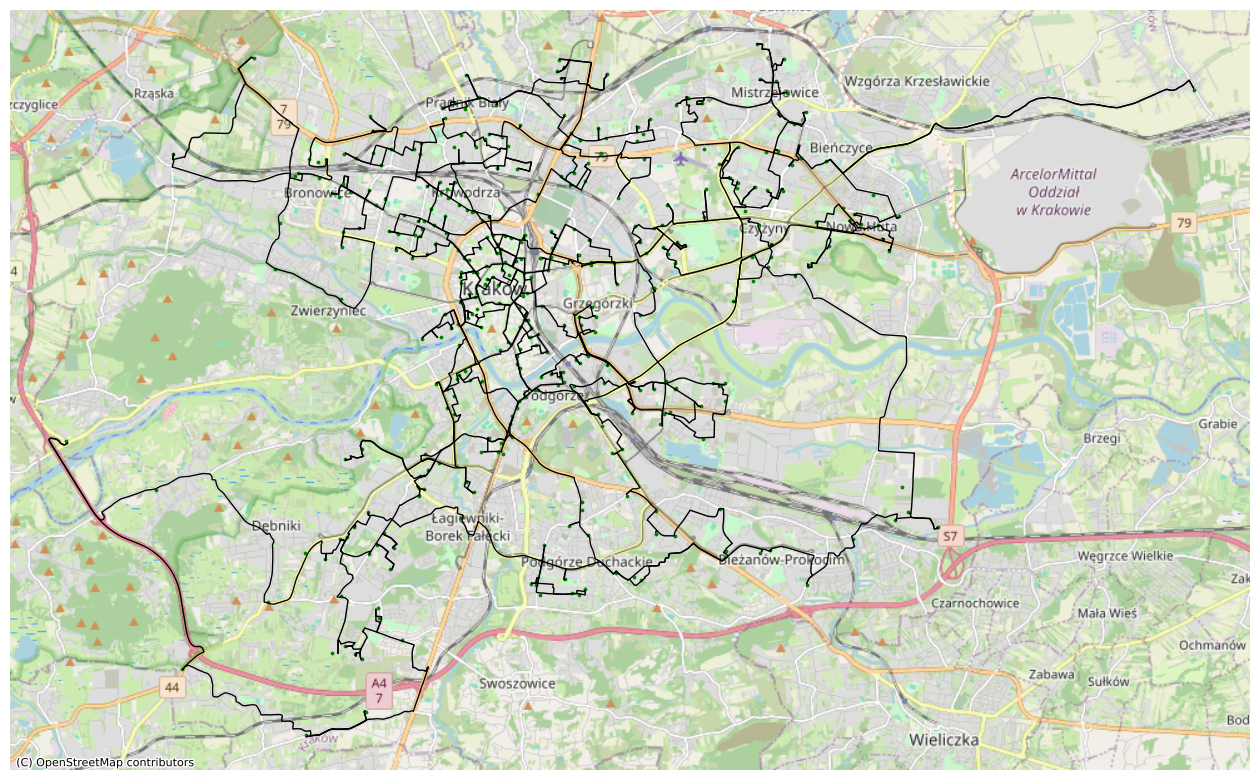

In [94]:
import contextily as ctx
fig, ax = plt.subplots(figsize=(16, 16))
zabki_gdf.to_crs(epsg=3857).plot(ax=ax, color='green', alpha=1, markersize=3)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.axis('off')


# path_gdf = gpd.GeoDataFrame(geometry=[routes_df.iloc[0]['path']])
# path_gdf.crs = 'EPSG:4326'
# path_gdf.to_crs(epsg=3857).plot(ax=ax, color='red', alpha=1, linewidth=1)


for i, row in tqdm.tqdm(routes_df.iterrows(), total=len(routes_df)):
    path_gdf = gpd.GeoDataFrame(geometry=[row['path']])
    path_gdf.crs = 'EPSG:4326'
    path_gdf.to_crs(epsg=3857).plot(ax=ax, color='black', linewidth=1, alpha=1)



c:\Users\bugaj\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(
MovieWriter imagemagick unavailable; using Pillow instead.


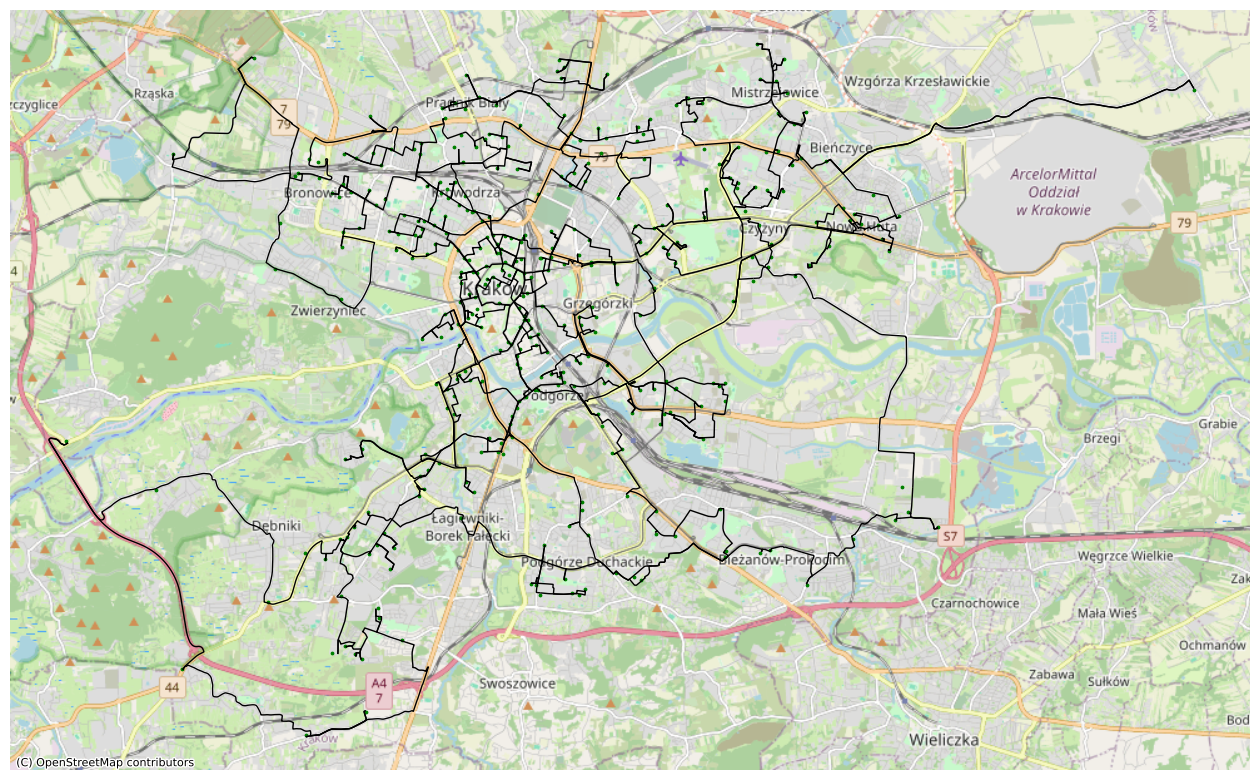

In [96]:
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from matplotlib.animation import FuncAnimation
import tqdm

# Tworzenie bazy wykresu
fig, ax = plt.subplots(figsize=(16, 16))
zabki_gdf.to_crs(epsg=3857).plot(ax=ax, color='green', alpha=1, markersize=3)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.axis('off')

# Inicjalizacja pustej linii, która będzie aktualizowana w animacji
line, = ax.plot([], [], color='black', linewidth=1)

def update(frame):
    # Czyść poprzednią ścieżkę
    line.set_data([], [])
    
    # Dodawanie kolejnej ścieżki
    path_gdf = gpd.GeoDataFrame(geometry=[routes_df.iloc[frame]['path']])
    path_gdf.crs = 'EPSG:4326'
    path_gdf.to_crs(epsg=3857).plot(ax=ax, color='black', linewidth=1, alpha=1)
    
    # Pobieranie współrzędnych ścieżki i ustawianie ich dla linii
    x, y = path_gdf.geometry.iloc[0].xy
    line.set_data(x, y)
    
    return line,

# Tworzenie animacji
ani = FuncAnimation(fig, update, frames=len(routes_df), interval=100)

# Zapisywanie animacji
ani.save('animation.gif', writer='imagemagick', fps=10)
